# 1. IMPORTS
---

## 1.1. Libraries

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

## 1.2. Helper functions

In [12]:
def plot_percentage_by_category(df, category_col, target_col, figsize=(10, 6)):
    """
    Plots a bar plot showing the percentage of target = 1 by category, with bars representing 100% behind.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the data.
    category_col (str): Column name for the categories (y-axis).
    target_col (str): Column name for the target values (x-axis).
    """
    # Change the category_col to str
    df[category_col] = df[category_col].astype(str)


    # Calculate the percentage of target = 1 for each category
    percentages = df.groupby(category_col)[target_col].mean() * 100

    # Calculate total count and percentage for each category relative to entire dataset
    total_count = df.groupby(category_col)[target_col].count()
    total_percentage = (total_count / df.shape[0]) * 100

    # Sort categories by descending order of percentages
    percentages = percentages.sort_values(ascending=False)
    total_percentage = total_percentage.reindex(percentages.index)  # Reindex to match order

    # Plotting
    plt.figure(figsize=figsize)  # Adjust the figure size as needed

    # Using Seaborn style and color palette
    sns.set_style("white")  # Remove grid and use white background

    # Light blue color for 100% bars
    color_100 = 'lightblue'

    # Single shade of blue for percentage bars
    color_percentage = 'steelblue'

    # Convert index to string for proper plotting
    categories = percentages.index.astype(str)

    # Plotting 100% bars
    bars_100 = plt.barh(categories, [100] * len(percentages), color=color_100, edgecolor='black')

    # Adding quantities and percentages on top of 100% bars
    for i, bar in enumerate(bars_100):
        category = categories[i]
        plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                 f'{total_count[category]} ({total_percentage[category]:.2f}%)',
                 va='center', ha='left', fontsize=10)

    # Plotting percentage bars
    bars = plt.barh(categories, percentages, color=color_percentage, edgecolor='black')

    # Adding percentages values inside the bars
    for bar in bars:
        plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}%',
                 va='center', ha='left', fontsize=10)

    # Removing spines (borders)
    sns.despine()

    # Adding labels and title
    plt.xlabel('Percentage (%)')
    plt.ylabel(category_col)
    plt.title(f'Percentage of {target_col} = 1 by {category_col}')

    # Show plot
    plt.show()




def plot_box_kde_by_category(df, x, category):
    """
    Plots a boxplot and a KDE plot ((Kernel Density Estimate) for a specified 
    category in a DataFrame.

    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame containing the data to be plotted.
    x : str
        The name of the column in the DataFrame to be plotted on the x-axis.
    category : str
        The name of the categorical column in the DataFrame to be plotted on the y-axis in the boxplot
        and used for hue in the kdeplot.

    Returns:
    --------
    None
        This function does not return any value. It directly creates and displays the plots.
    """
    fig, axes = plt.subplots(2, 1, figsize=(9, 6), sharex=True)

    sns.boxplot(x=x, y=category, data=df, ax=axes[0], orient='h', fill=False)
    sns.kdeplot(x=x, hue=category, data=df, ax=axes[1], common_norm=False)
    fig.suptitle(f'{category} by {x} distribution')

    sns.despine()




def mann_whitney_test(sample1, sample2, alpha=0.05):
    """
    Perform the Mann-Whitney U test for two independent samples.

    Parameters:
    sample1 (list or array-like): The first sample of data.
    sample2 (list or array-like): The second sample of data.
    alpha (float): The significance level (default is 0.05).

    Returns:
    stat (float): The Mann-Whitney U statistic.
    p_value (float): The p-value associated with the test.
    result (str): The conclusion of the hypothesis test.
    """
    # Perform the Mann-Whitney U test
    stat, p_value = stats.mannwhitneyu(sample1, sample2)
    
    # Print the results
    print(f"Mann-Whitney U statistic: {stat}")
    print(f"p-value: {p_value}")

    # Interpret the result
    if p_value < alpha:
        result = "We reject the null hypothesis. The samples are significantly different."
    else:
        result = "We fail to reject the null hypothesis. There is no significant difference between the samples."

    print(result)
    return stat, p_value, result




def cramer_v(x, y):
    """
    Calculate Cramér's V statistic for categorical-categorical association.

    Cramér's V is a measure of association between two nominal variables, giving a value between 0 and 1.
    A value of 0 indicates no association between the variables, while a value of 1 indicates perfect association.

    Parameters:
    -----------
    x : array-like
        The first categorical variable.
    y : array-like
        The second categorical variable.

    Returns:
    --------
    float
        Cramér's V statistic.
        
    Notes:
    ------
    This function calculates Cramér's V with bias correction as described in Bergsma (2013).
    """
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape

    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    v = np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

    return v

# 2. EXPLORATORY DATA ANALYSIS (EDA)
---

In [13]:
# Importing the data
df_eda = pd.read_csv('../data/interim/hi_cs_processed.csv')

## 2.1. Univariate analysis

### 2.1.1. Response variable

In [14]:
count = pd.DataFrame(df_eda['response'].value_counts())
prop = pd.DataFrame(df_eda['response'].value_counts(normalize=True))

grouped_info = count.join(prop)
display(round(grouped_info, 3))

,count,proportion
response,,
0,460428,0.908
1,46669,0.092


Like I already said, we are working with imbalanced data. We have to use models that fit well with this kind of problems.

### 2.1.2. Numerical variables

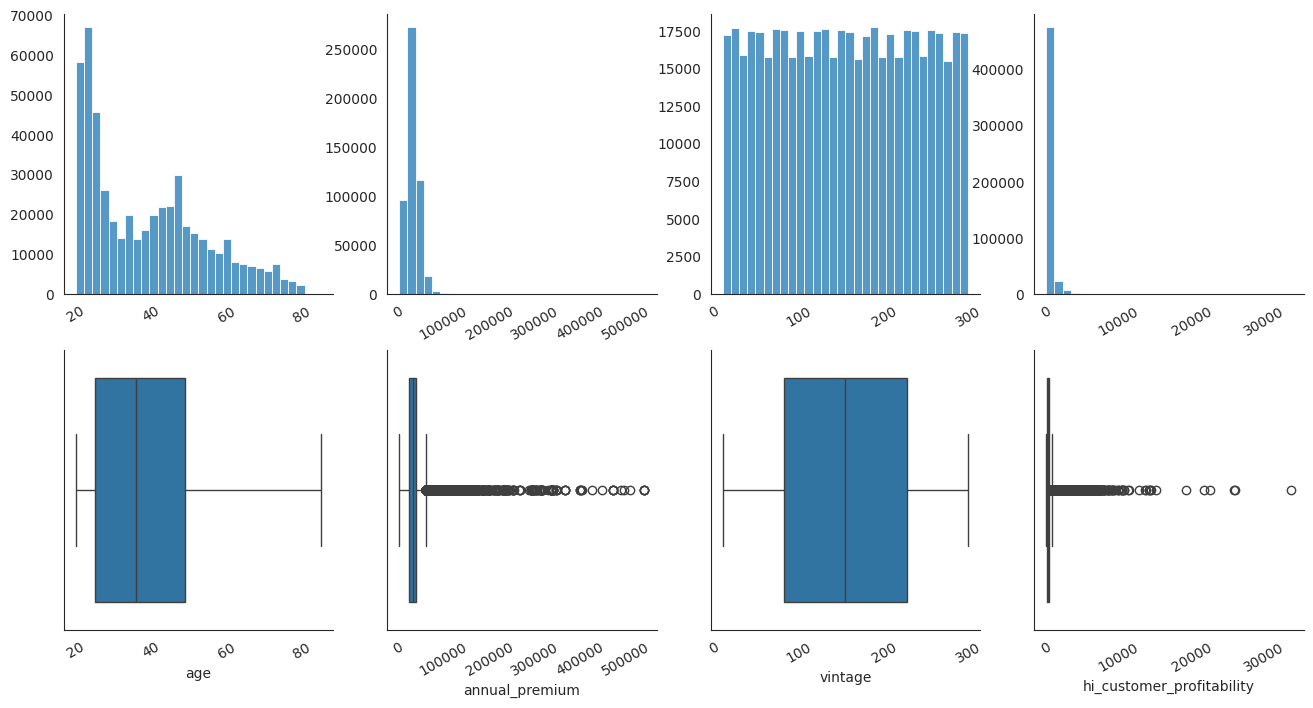

In [15]:
# Plotting all the histograms and boxplots
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

num_vars = ['age', 'annual_premium', 'vintage', 'hi_customer_profitability']

for i, var in enumerate(num_vars):
    sns.histplot(x=var, data=df_eda, ax=axes[i], bins=30)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

for i, var in enumerate(num_vars):
    sns.boxplot(x=var, data=df_eda, ax=axes[i+4])

for ax in axes:
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)

sns.despine();

- `age` has a right tail in distribution and the mode is between 20 and 25 years old
- `vintage` has a symmetric distribution, close to the uniform

### 2.1.3. Categorical variables

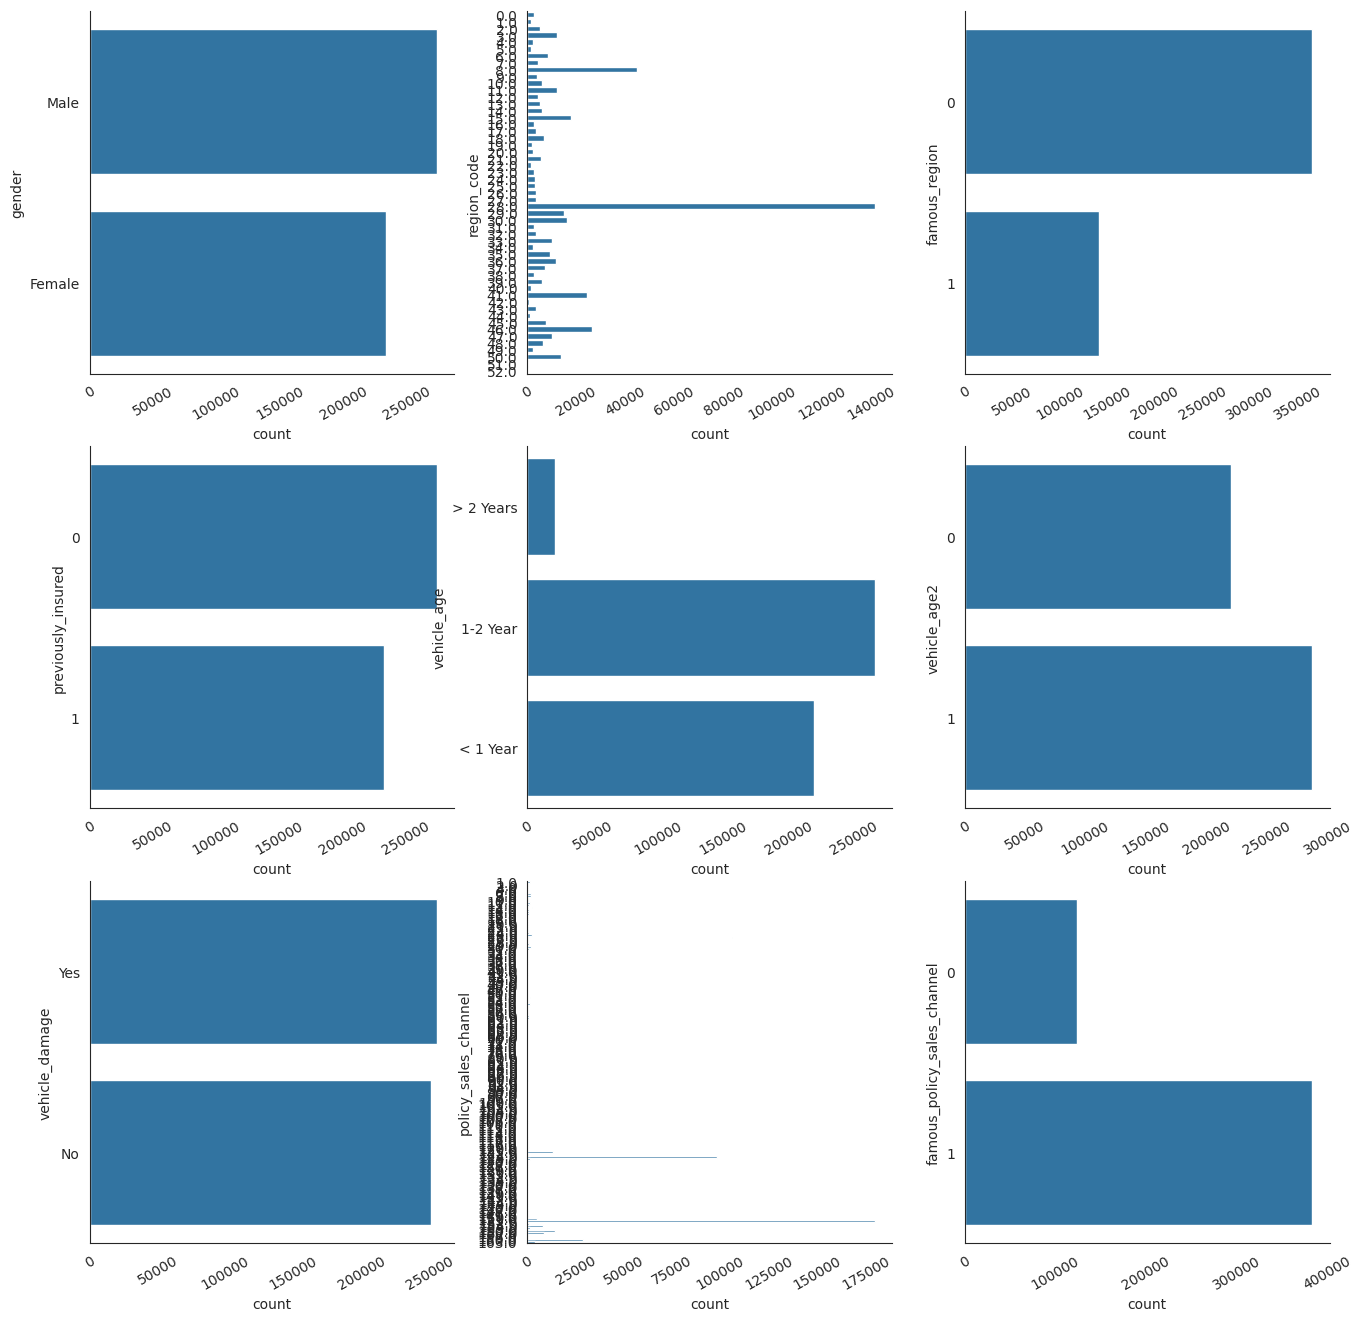

In [16]:
# Plotting the countplots
fig, axes = plt.subplots(3, 3, figsize=(16, 16))
axes = axes.flatten()

sns.countplot(y='gender', data=df_eda, ax=axes[0])
sns.countplot(y='region_code', data=df_eda, ax=axes[1])
sns.countplot(y='famous_region', data=df_eda, ax=axes[2])
sns.countplot(y='previously_insured', data=df_eda, ax=axes[3])
sns.countplot(y='vehicle_age', data=df_eda, ax=axes[4])
sns.countplot(y='vehicle_age2', data=df_eda, ax=axes[5])
sns.countplot(y='vehicle_damage', data=df_eda, ax=axes[6])
sns.countplot(y='policy_sales_channel', data=df_eda, ax=axes[7])
sns.countplot(y='famous_policy_sales_channel', data=df_eda, ax=axes[8])

for ax in axes:
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)

sns.despine();

- There are a lot of distinct items on `region_code` and `policy_sales_channel`. These are flags to drop these variables from data
- The `famous_policy_channel` = 1 has the largest amount of data
- There is a low quantity of `vehicle_age` > 2 years, so adding this classification to >= 1 year, maybe it's a good idea


## 2.2. Bivariate analysis

### 2.2.1. $H_{1}$: Different policy sales channel of health insurance doesn't change the vehicle insurance interest

**FALSE**. We can observe that **different policy sales channels have different percentage of responses**.

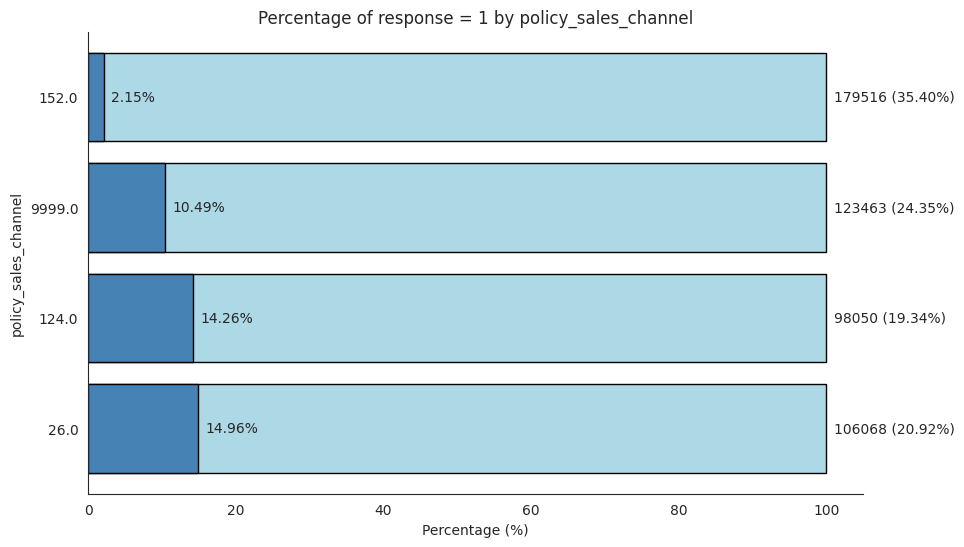

In [17]:
# Plotting the response by top 3 popular policy_sales_channel
top_three_pc = list(df_eda['policy_sales_channel']\
            .value_counts()\
            .reset_index()\
            .head(3)['policy_sales_channel'])

df_eda.loc[~df_eda['policy_sales_channel'].isin(top_three_pc), 'policy_sales_channel'] = 9999

plot_percentage_by_category(df_eda, 'policy_sales_channel', 'response')

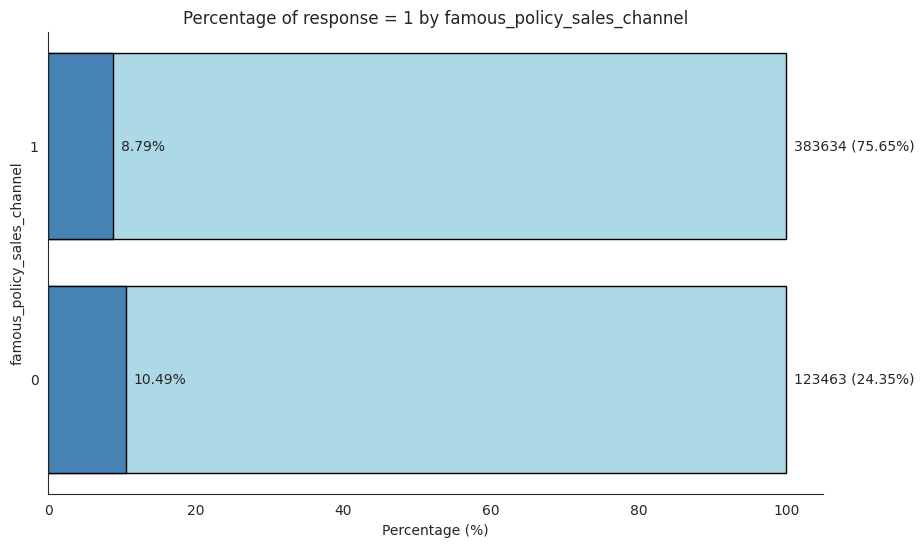

In [18]:
# Famous policy_sales_channel
plot_percentage_by_category(df_eda, 'famous_policy_sales_channel', 'response')

We can observe that **different policy sales channels have different percentage of responses**. Maybe I'll use the **top three divison** for modelling, because the classes have **near quantities** and the percentage of responses = 1 in code 152 is a little different compared between other codes.

### 6.2.2. $H_{2}$: The higher annual premium price on health insurance, the lower the interest on vehicle insurance

**TRUE**. There are more outliers on not interested people.

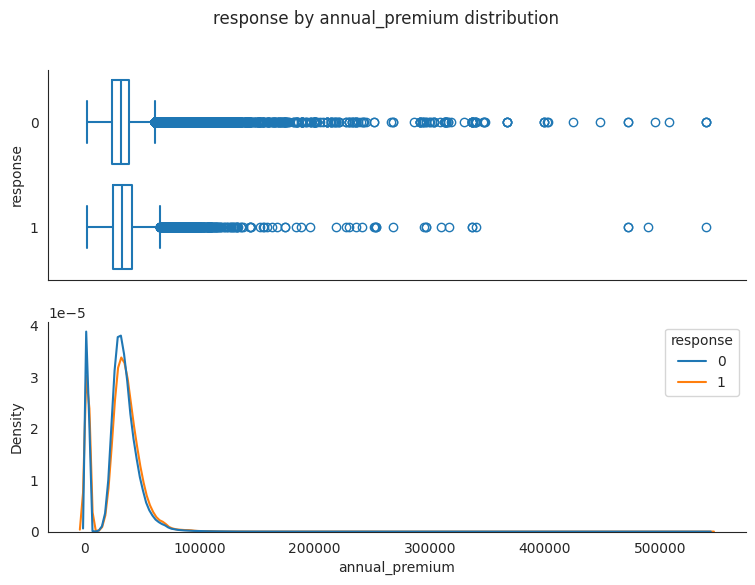

In [19]:
plot_box_kde_by_category(df_eda, 'annual_premium', 'response')

The distributions of `annual_premium` are very similar... The outliers is a little different, but they're few points...

In [20]:
mann_whitney_test(df_eda[df_eda['response'] == 1]['annual_premium'], 
                  df_eda[df_eda['response'] == 0]['annual_premium']);

Mann-Whitney U statistic: 11370428328.0
p-value: 1.7052591359565896e-96
We reject the null hypothesis. The samples are significantly different.


Okay, the outliers are making the difference between these samples...

### 2.2.3. $H_{3}$: The higher vintage on health insurance, the greater the interest in vehicle insurance

**FALSE**. Higher vintage on health insurance doesn't make any difference on interest in vehicle insurance.

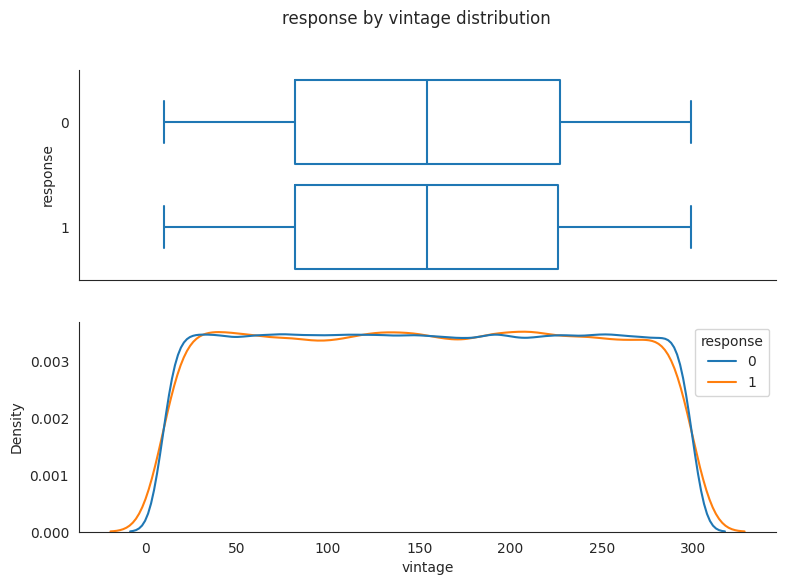

In [21]:
plot_box_kde_by_category(df_eda, 'vintage', 'response')

In [22]:
mann_whitney_test(df_eda[df_eda['response'] == 1]['vintage'], 
                  df_eda[df_eda['response'] == 0]['vintage']);

Mann-Whitney U statistic: 10726229956.5
p-value: 0.5585659779692942
We fail to reject the null hypothesis. There is no significant difference between the samples.


### 2.2.4. $H_{4}$: Customers living on famous regions are more interested on vehicle insurance

**TRUE**. If the customer is from `region_code` = 28, then the percentage of interest in vehicle insurance is greater, compared to other `region_code`s. 

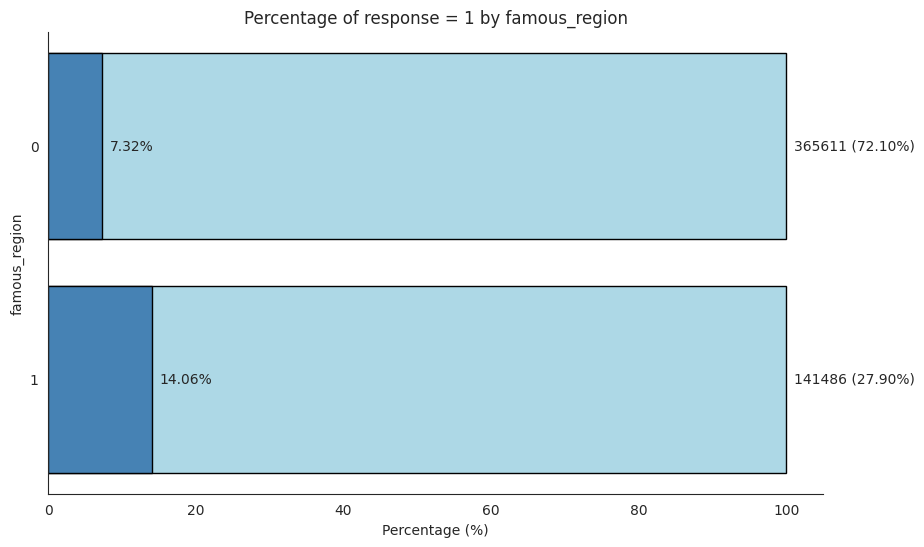

In [23]:
plot_percentage_by_category(df_eda, 'famous_region', 'response')

### 2.2.5. $H_{5}$: Older customers have more interest on vehicle insurance

**TRUE**. The older customers have more interest on vehicle insurance, when comparing the median from interest distributions.

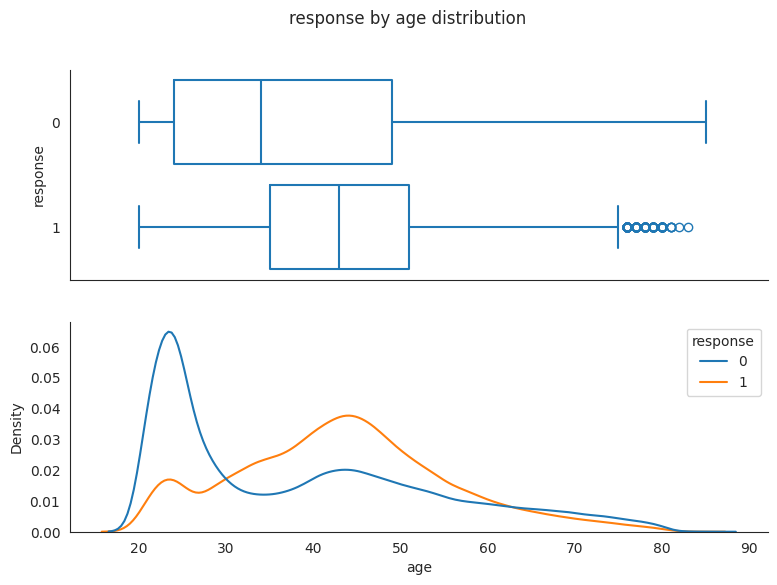

In [24]:
plot_box_kde_by_category(df_eda, 'age', 'response')

In [25]:
mann_whitney_test(df_eda[df_eda['response'] == 1]['age'],
                  df_eda[df_eda['response'] == 0]['age']);

Mann-Whitney U statistic: 13407779812.0
p-value: 0.0
We reject the null hypothesis. The samples are significantly different.


### 2.2.6. $H_{6}$: There is a difference between genders when comparing the vehicle insurance interest

**TRUE**. When comparing genders, there is a little difference on interest in vehicle insurance.

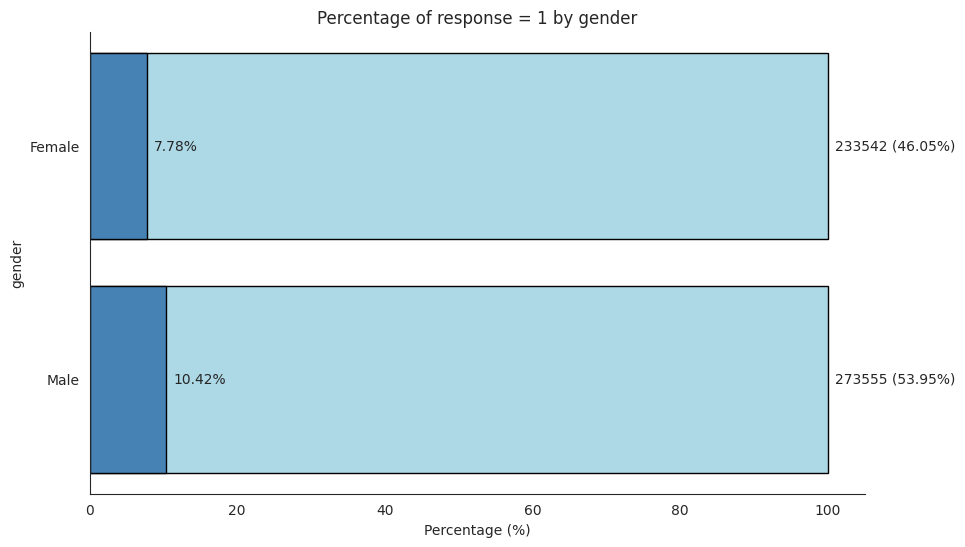

In [26]:
plot_percentage_by_category(df_eda, 'gender', 'response')

### 2.2.7. $H_{7}$: If the customer already has vehicle insurance, then the customers will have more interest on the insurance of our company

**TRUE**. If the customer already has vehicle insurance, the interest on our vehicle insurance is **lower**. So, the recomendation is to not offer our insurance to them.

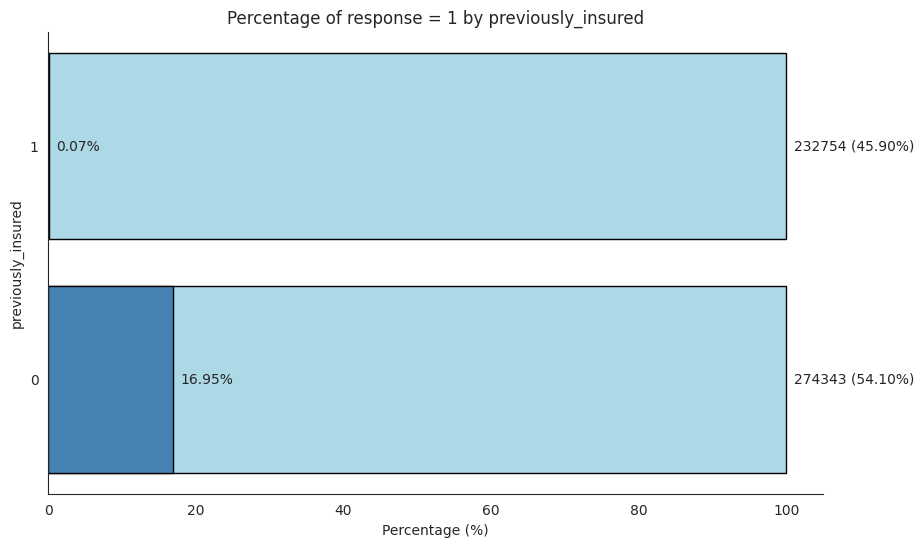

In [27]:
plot_percentage_by_category(df_eda, 'previously_insured', 'response')

### 2.2.8. $H_{8}$: Customers with older vehicle have less interest on vehicle insurance

**FALSE**. Customers with older vehicle have **more interest** on vehicle insurance. This is curious too, people with less vehicle age tend to preserve their vehicles earlier...

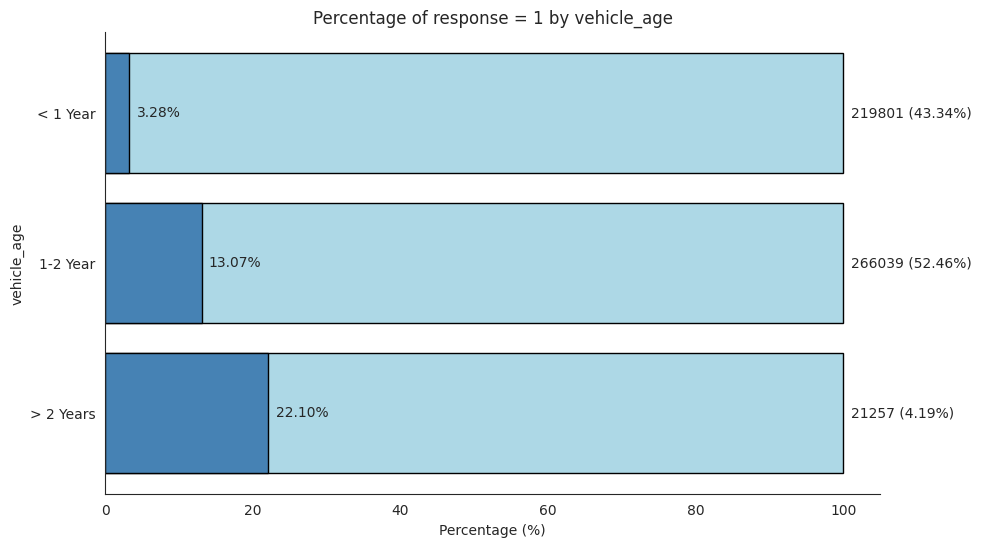

In [28]:
plot_percentage_by_category(df_eda, 'vehicle_age', 'response')

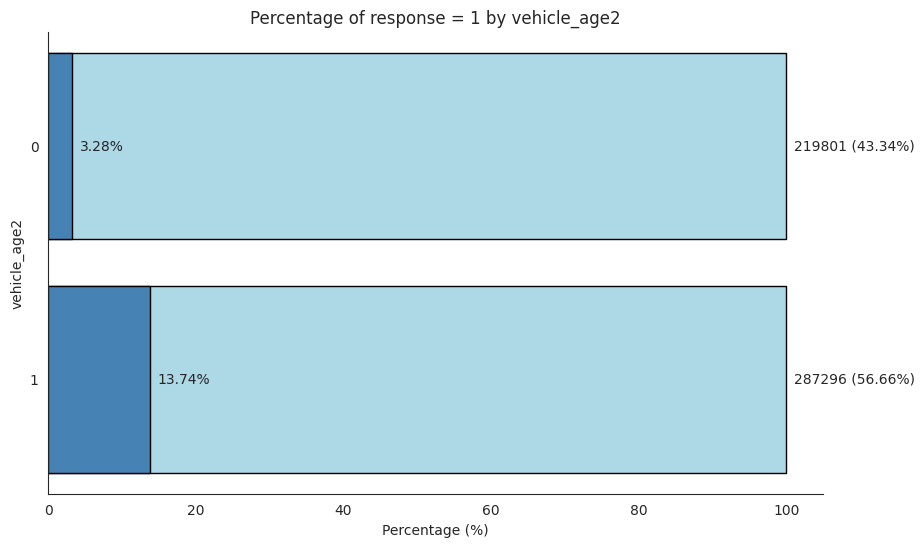

In [29]:
plot_percentage_by_category(df_eda, 'vehicle_age2', 'response')

### 2.2.9. $H_{9}$: If the vehicle has been damaged, then the vehicle insurance interest is greater

**TRUE**. If the vehicle has been damaged, normally people want a vehicle insurance.

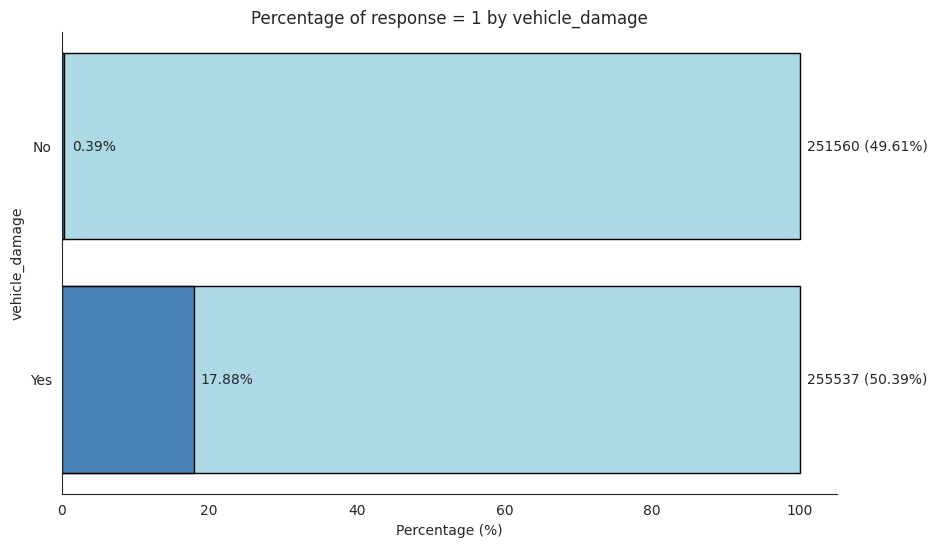

In [30]:
plot_percentage_by_category(df_eda, 'vehicle_damage', 'response')

### 2.2.10. $H_{10}$: Customers more profitable are more interested on vehicle insurance

**FALSE**. Customers less profitable are more interested on vehicle insurance, but the interest distributions are very similar... Maybe this variable isn't important.

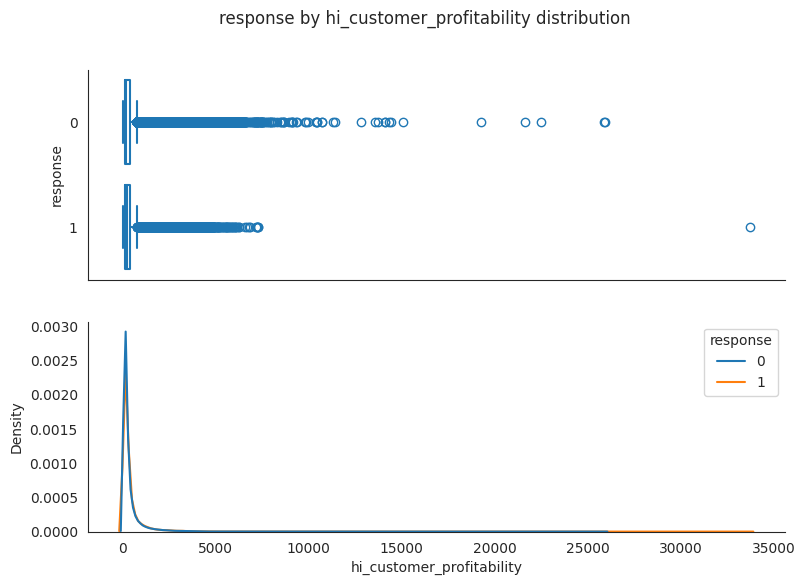

In [31]:
plot_box_kde_by_category(df_eda, 'hi_customer_profitability', 'response')

In [32]:
mann_whitney_test(df_eda[df_eda['response'] == 1]['hi_customer_profitability'],
                  df_eda[df_eda['response'] == 0]['hi_customer_profitability']);

Mann-Whitney U statistic: 10928019486.0
p-value: 9.867692640435383e-10
We reject the null hypothesis. The samples are significantly different.


The same case of `annual_premium`...

### 2.2.11. EDA feature importances

|Variable|Importance|
|--------|----------|
|previously_insured|High|
|vehicle_damage|High|
|vehicle_age2|High|
|age|Medium|
|famous_region|Medium|
|policy_sales_channel2*|Medium|
|gender|Medium|
|annual_premium|Low|
|vintage|Low|
|hi_customer_profitability|Low|

*: I'll create `policy_sales_channel2`, it'll be the top three most famous `policy_sales_channel` and the other channels classification.

**Note:** If the car has vehicle insurance, this would be a business rule and not a model feature. `previously_insured` will bias our model.

## 2.3. Multivariate exploratory analysis

In [33]:
# Defining the numerical and categorical dfs
num_attributes2 = df_eda[['age', 'annual_premium', 'vintage', 'hi_customer_profitability']]


cat_attributes2 = df_eda[['gender', 'famous_region', 'previously_insured', 
                        'vehicle_age', 'vehicle_age2', 'vehicle_damage', 
                        'famous_policy_sales_channel', 'response']]

### 2.3.1. Numerical Attributes

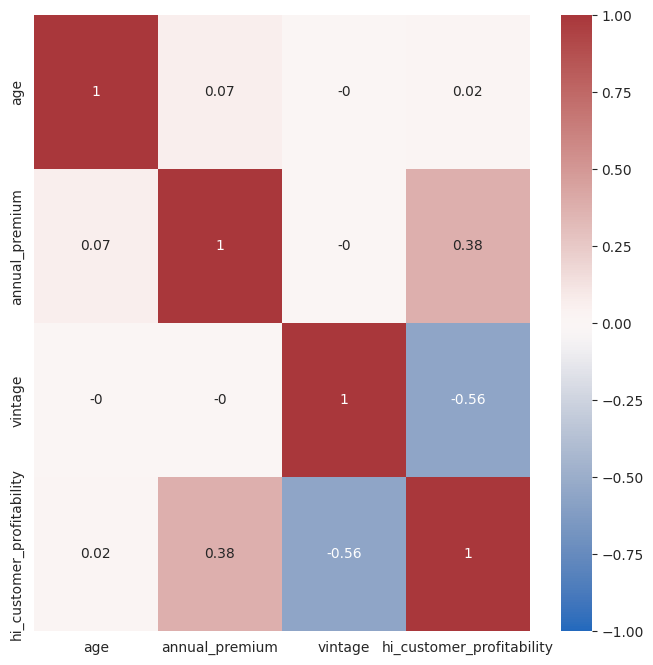

In [34]:
# Correlation matrix
corr = round(num_attributes2.corr(method='pearson'), 2)

# Heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, cmap='vlag');

Low correlation between other variables and an expected correlation between `hi_customer_profitability` vs `annual_premium` and vs `vintage`.

### 2.3.2. Categorical attributes

In [35]:
# Creating the confusion matrix of cramer v values
wanted_columns = cat_attributes2.columns
cm = pd.DataFrame(columns=wanted_columns)

for col1 in wanted_columns:
    v_values = []
    for col2 in wanted_columns:
        v = cramer_v(cat_attributes2[col1], cat_attributes2[col2])
        v_values.append(v)
    cm[col1] = v_values
cm = cm.set_index(wanted_columns)

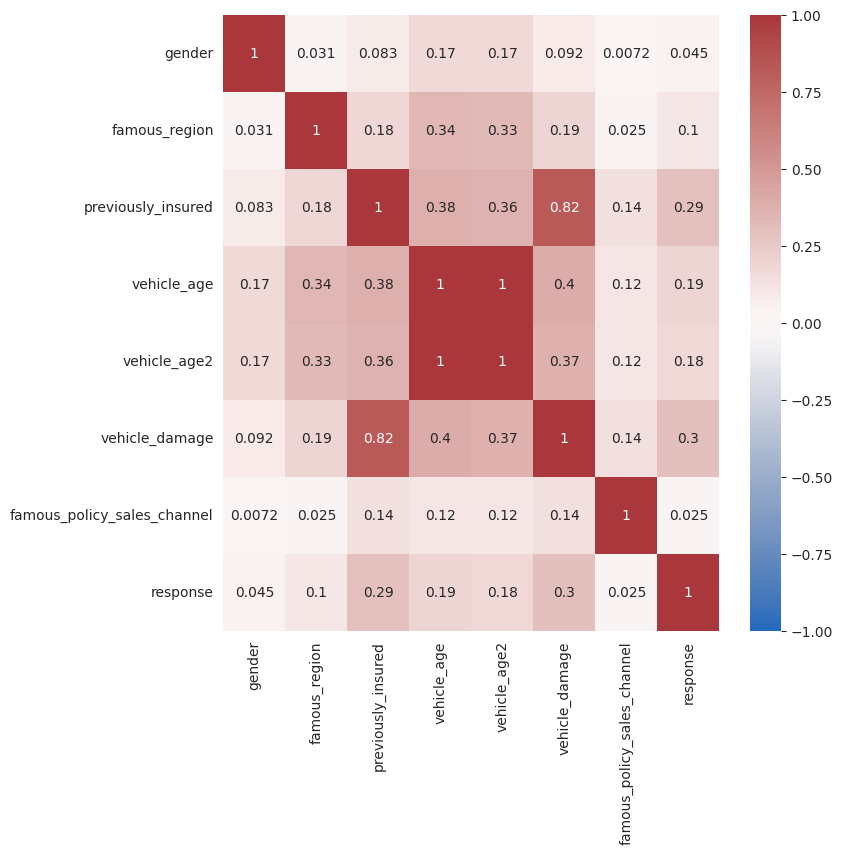

In [36]:
# Heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=-1, vmax=1, cmap='vlag');

- There is a high correlation between `vehicle_damage` and `previously_insured`
    - Maybe if the vehicle has been damaged, people tend to be more careful with their vehicles and get a vehicle insurance earlier
- `vehicle_age` is more correlated to other variables, when compared with `vehicle_age2`